In [1]:
#attempt to improve the NN
#add the local and the global view construct coz transit false positive mismatch seems to be a major problem
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import backend as K
import GetLightcurves as gc

In [45]:
Xtrain, Ytrain, Ctrain, TrainID = gc.read_tfr_record('../../training_data/seg_mask_training_av_spaced',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

Xtest, Ytest, Ctest, TestID = gc.read_tfr_record('../../training_data/seg_mask_test_av_spaced',
    ['input','map','counts','id'],
    ['ar','ar','ar','b'], 
    [tf.float32, tf.bool, tf.int8, tf.string])

In [46]:
Ytrain=np.asarray(Ytrain).reshape(len(Xtrain),4000,3)
Ytest=np.asarray(Ytest).reshape(len(Xtest),4000,3)
print(Ytrain.shape, Ytest.shape)

(4548, 4000, 3) (1138, 4000, 3)


In [47]:
Xtrainf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtrain])
Xtestf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
#Xtrainf=np.asarray([row-np.median(row) for row in Xtrain])
#Xtestf=np.asarray([row-np.median(row) for row in Xtest])
#Xtrainf=np.asarray([np.tanh(100*row) for row in Xtrainf])
#Xtestf=np.asarray([np.tanh(100*row) for row in Xtestf])

#Xtrainf=np.asarray([0.5*(np.tanh(0.1*(row - np.median(row))/np.std(row))) for row in Xtrain])
#Xtestf=np.asarray([0.5*(np.tanh(0.1*(row - np.median(row))/np.std(row))) for row in Xtest])

In [42]:
for i in range(0,len(Xtrain)):
    if(np.any(Ytrain[i,:,0]==1) and np.any(Ytrain[i,:,1]==1)):
        print(i)

209
247
349
381
436
503
557
622
724
748
974
996
1142
1160
1235
1460
1606
1652
1659
1825
2062
2096
2271
2473
2558
2663
2825
2940
3145
3266
3443
3453
3486
3703
3706
4069
4112
4199
4301
4797
5068
5472
5540
5686
5921
5932
5990
6039
6148
6163
6267
6319
6398
6425
6618
6663
6673
6686
6696
6773
6840
6849
6861
6869
7126
7157
7192


<function matplotlib.pyplot.show(close=None, block=None)>

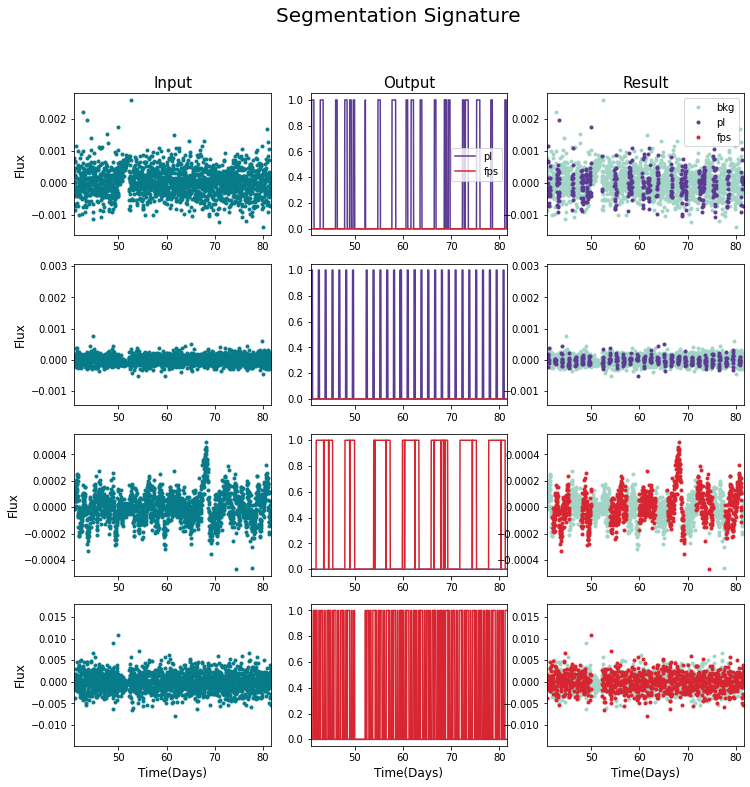

In [48]:
Ytrain = np.asarray(Ytrain, dtype = 'float32')
Ytest = np.asarray(Ytest, dtype = 'float32')
vararr=np.random.randint(0,len(Xtrain),size=10)
vararr=[5,247,3,375]
#vararr=[375,376,396,442,456,613]
fig,ax=plt.subplots(4,3,figsize=(12,12))
j=0

xaxis = np.arange(0,4000,1)*29.5/1440
plt.suptitle('Segmentation Signature',size=20)
ax[0][0].set_title('Input',size=15)
ax[0][1].set_title('Output',size=15)
ax[0][2].set_title('Result',size=15)

ax[3][0].set_xlabel('Time(Days)',size=12)
ax[3][1].set_xlabel('Time(Days)',size=12)
ax[3][2].set_xlabel('Time(Days)',size=12)
for i in range(0,4):
    ax[i][0].plot(np.arange(0,4000,1)*29.4/1440,Xtrain[vararr[i]],color='#077b8a',marker='.',ls='None')
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in Ytrain[vararr[i]]])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    #predpl = np.where(Ytest[ar[i],:,0]==1)[0]
    bkg=np.where(counts==2)[0]
    ax[i][0].set_ylabel('Flux',size=12)
    ax[i][2].plot(bkg*29.4/1440,Xtrain[vararr[i]][bkg],marker='.',ls='None',color='#a2d5c6',label='bkg')
    ax[i][2].plot(pl*29.4/1440,Xtrain[vararr[i]][pl],marker='.',ls='None',color='#5c3c92',label='pl')
    ax[i][2].plot(fps*29.4/1440,Xtrain[vararr[i]][fps],marker='.',ls='None',color='#d72631',label='fps')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,0],color='#5c3c92',label='pl')
    ax[i][1].plot(np.arange(0,4000,1)*29.4/1440,Ytrain[vararr[i],:,1],color='#d72631',label='fps')
    ax[0][1].legend()
    ax[0][2].legend()
    ax[i][2].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][1].set_xlim(2000*29.4/1440,4000*29.4/1440)
    ax[i][0].set_xlim(2000*29.4/1440,4000*29.4/1440)
plt.savefig('fprez_segmentation2')
plt.show

In [56]:

def dice_coeff(y_true, y_pred):
    smooth = 0.00001
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection +smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) +smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def weightFocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA): 
    w = tf.reduce_sum(targets,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 - w
    #w = 1 / (w  + 0.00001)
    #w = w**2
    w=tf.cast(w,tf.float32)   
    
    #inputs = K.flatten(inputs)
    #targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(w*K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    #w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def generalized_dice_coeff_v2(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w**2  + 0.00001)

    z=tf.slice(w,[0],[2])
    z2 = tf.slice(w,[2],[1])
    z=tf.reduce_mean(z)
    z2=tf.reduce_mean(z2)
    w =  tf.stack([z,z*0.7,z2])

    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def focal_dice_loss(y_true, y_pred):
    loss = FocalLoss(y_true, y_pred) + 1.5*generalized_dice_coeff(y_true, y_pred)
    return loss

#print(weightFocalLoss(Ytest, np.ones((len(Ytest),4000,3),dtype='float32')))



In [59]:
IMG_SIZE=4000
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.SeparableConv1D(16,kernel_size=3,activation='tanh',name='1st16_5')(xi)  #3998, 32
c1=keras.layers.SeparableConv1D(16,kernel_size=3,strides=1,activation='tanh',name='2nd16_3')(x1)  #3996, 32

x2=keras.layers.BatchNormalization(name='bn1')(c1)
#x2=keras.layers.MaxPool1D(2,strides=2 ,data_format='channels_last',name='maxpool_1')(x2)  #1998, 64
x2=keras.layers.Conv1D(16,kernel_size=1,strides=2,name='maxpool_1')(x2)  #1998, 64
x2=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',name='1st32_5')(x2) #1996, 64
c2=keras.layers.SeparableConv1D(32,kernel_size=5,strides=1,activation='tanh',name='2nd32_3')(x2) #1992, 64

x3=keras.layers.BatchNormalization(name='bn2')(c2) 
x3=keras.layers.Conv1D(32,kernel_size=1,strides=2,name='maxpool_2')(x3)  #996, 64
x3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='1st64_5')(x3) #994, 128
c3=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',name='2nd64_3')(x3) #992, 128

x4=keras.layers.BatchNormalization(name='bn3')(c3)
x4=keras.layers.Conv1D(64,kernel_size=1,strides=2,name='maxpool_3')(x4)  #496, 128
x4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='1st128_5')(x4)  #494, 256
c4=keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='tanh',name='2nd128_5')(x4) #492, 256

x5=keras.layers.BatchNormalization(name='bn4')(c4) 
x5=keras.layers.Conv1D(128,kernel_size=1,strides=2,name='maxpool_4')(x5)  #246, 256  
x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='tanh',name='1st512_5')(x5)  #244, 256
x5=keras.layers.SeparableConv1D(512,kernel_size=3,strides=1,activation='tanh',name='2nd512_5')(x5)  #242, 256

x5 = keras.layers.Conv1DTranspose(128, kernel_size=4, activation='relu', strides=2, name="T1st128_5")(x5)  #486, 256
x5 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', strides=1, name="T2nd128_5")(x5)  #490, 256
x5 = keras.layers.Conv1DTranspose(128, kernel_size=3, activation='relu', strides=1, name="T3rd128_5")(x5)  #492, 256
x5 =keras.layers.BatchNormalization(name='bn5')(x5) 

#c4 = keras.layers.Cropping1D((2,2))(c4) #488, 256
x6 = keras.layers.Concatenate(axis=2, name='cn1')([c4,x5])  #492, 512
x6 = keras.layers.Conv1DTranspose(128,kernel_size=3,strides=1,activation='relu',name='3rd128_3')(x6) #494, 256
x6 = keras.layers.Conv1DTranspose(64, kernel_size=4, activation='relu', strides=2, name="T1st64_3")(x6) #990, 128
x6 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', strides=1, name="T2nd64_3")(x6) #992, 128
x6 = keras.layers.BatchNormalization(name='bn6')(x6)  

#c3 = keras.layers.Cropping1D((4,4))(c3) #984, 128
x7 = keras.layers.Concatenate(axis=2, name='cn2')([c3,x6]) #992, 256
x7 = keras.layers.Conv1DTranspose(64,kernel_size=3,strides=1,activation='relu',name='3rd64_3')(x7) #994, 128
x7 = keras.layers.Conv1DTranspose(32, kernel_size=4, activation='relu', strides=2, name="T1st32_3")(x7) #1990, 64
x7 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', strides=1, name="T2nd32_3")(x7) #1992, 64
x7 = keras.layers.BatchNormalization(name='bn7')(x7)  

x8 = keras.layers.Concatenate(axis=2, name='cn3')([c2,x7])  #1992, 128
x8 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=1,activation='relu',name='3rd32_3')(x8)  #1994, 64
x8 = keras.layers.Conv1DTranspose(16,kernel_size=4,strides=2,activation='relu',name='T1st16_3')(x8) #3990, 32
x8 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T2nd16_3')(x8) #3994, 32
x8 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='T4rth16_3')(x8) #3996, 32
x8 = keras.layers.BatchNormalization(name='bn8')(x8)  

#c1 = keras.layers.Cropping1D((1,1))(c1) #3994, 32
x9 = keras.layers.Concatenate(axis=2, name='cn4')([c1,x8])  #3996, 64
x9 = keras.layers.Conv1DTranspose(16,kernel_size=3,strides=1,activation='relu',name='3rd16_3')(x9) #3998, 32
x9 = keras.layers.Conv1DTranspose(16,kernel_size=5,strides=1,activation='relu',name='T3rd16_3')(x9) #4002, 32
x9 = keras.layers.BatchNormalization(name='bn9')(x9)

conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,name='semiop',activation='softmax')(x9) # (4000, 3)

keras.backend.clear_session()
convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=focal_dice_loss ,metrics=[dice_coeff] )

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
1st16_5 (SeparableConv1D)       (None, 3998, 16)     35          batch_normalization[0][0]        
___________________________________________________________________________________

In [58]:
X_trainf,X_valf,Y_train,Y_val = train_test_split(Xtrainf, Ytrain, test_size=0.2, shuffle=True)
print(X_trainf.shape, X_valf.shape)

(3638, 4000) (910, 4000)


In [67]:
#convNN.load_weights('newtests.h5')
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit(np.asarray(X_trainf),np.asarray(Y_train), batch_size=16, epochs=10   , verbose=1,
     validation_data=(X_valf, Y_val))    

Epoch 1/10
228/228 [==============================] - 113s 498ms/step - loss: 0.9548 - dice_coeff: 0.7182 - val_loss: 1.0087 - val_dice_coeff: 0.7061
Epoch 2/10
228/228 [==============================] - 113s 497ms/step - loss: 0.9566 - dice_coeff: 0.7168 - val_loss: 1.0004 - val_dice_coeff: 0.6980
Epoch 3/10
228/228 [==============================] - 115s 506ms/step - loss: 0.9472 - dice_coeff: 0.7190 - val_loss: 0.9723 - val_dice_coeff: 0.7196
Epoch 4/10
228/228 [==============================] - 113s 497ms/step - loss: 0.9464 - dice_coeff: 0.7186 - val_loss: 0.9815 - val_dice_coeff: 0.7164
Epoch 5/10
228/228 [==============================] - 113s 497ms/step - loss: 0.9314 - dice_coeff: 0.7186 - val_loss: 0.9711 - val_dice_coeff: 0.7179
Epoch 6/10
228/228 [==============================] - 113s 498ms/step - loss: 0.9362 - dice_coeff: 0.7186 - val_loss: 0.9760 - val_dice_coeff: 0.7158
Epoch 7/10
228/228 [==============================] - 115s 506ms/step - loss: 0.9273 - dice_coeff: 0

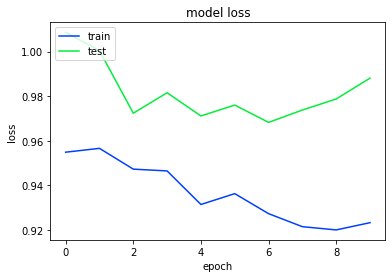

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('fprez_segment.png')
plt.show()

In [73]:
convNN.save('newtests3.h5')
#convNN.load_weights('tests.h5')
#convNN.save('newtests2.h5')

In [69]:
pred_op=convNN.predict(np.array(Xtestf))

In [ ]:
#model = keras.models.load_model('tests.h5',custom_objects={'focal_dice_loss': focal_dice_loss})
#Xtestf=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in Xtest])
#pred_op = model.predict(Xtestf)

In [39]:
TestID2 = [str(TestID[i])[2:13] for i in range(0,len(TestID))]
#print(TestID2)

Text(0.5, 0, 'Phase')

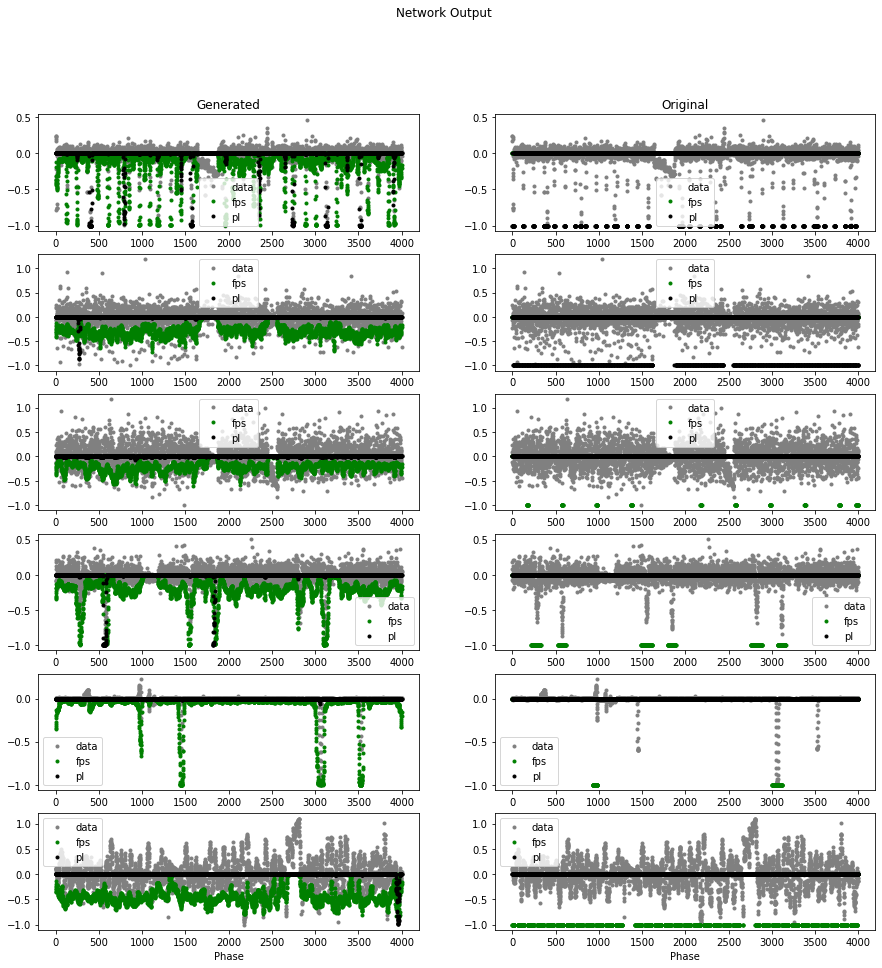

In [71]:

from sklearn.metrics import mean_squared_error
#convNN.load_weights('long_hard_battle_eq.h5')
Xtest = np.asarray(Xtest)

fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
ar=np.random.randint(len(Xtest),size=10)
#ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    #m = min(Xtestf)
    ax[i][0].plot(Xtestf[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='gray',ls='None',marker='.',label='pl')

    ax[i][1].plot(Xtestf[ar[i],:],color='gray',ls='None',marker='.',label='data')
    #ax[i][1].plot(-Ytest[ar[i],:,1],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    ax[i][0].legend('flux')
    #ax[i][0].set_ylim(-1.05,0.1)
    #ax[i][1].set_ylim(-1.05,0.1)
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')

#plt.savefig('present_itsamust')


In [72]:
#wholesome thing.... lets see if this is any better
corrects = 0 
incorrects = 0
cm=[[0,0],[0,0]]
pred_arr=[]


for i in range(0, len(Xtest)):
    tmp=[0,0]
    newpl=np.asarray(pred_op[i,:,0])
    newfps=np.asarray(pred_op[i,:,1])
    #newpl=np.asarray([1 if(el>np.mean(newpl)+np.std(newpl)) else 0 for el in newpl])
    #newfps=np.asarray([1 if(el>np.mean(newfps)+np.std(newfps)) else 0 for el in newfps])
    if(np.any(Ytest[i,:,0]>0)):
        val1 = np.corrcoef(newfps, Ytest[i,:,0])
        val2 = np.corrcoef(newpl, Ytest[i,:,0])
        if(val2[0,1]>val1[0,1]): 
            corrects+=1
            cm[0][0]+=1
            tmp[0]=1
        else: 
            incorrects+=1
            cm[1][0]+=1
            tmp[1]=1
        #print(val1[0,1], val2[0,1])
    #fps detect
    elif(np.any(Ytest[i,:,1]>0)):
        val1 = np.corrcoef(newfps, Ytest[i,:,1])
        val2 = np.corrcoef(newpl, Ytest[i,:,1])
        if(val1[0,1]>val2[0,1]): 
            corrects+=1
            cm[1][1]+=1
            tmp[1]=1
        else: 
            cm[0][1]+=1
            incorrects+=1
            tmp[0]=1
        #print(val1[0,1], val2[0,1])
    pred_arr.append(tmp)
    #planet detection:
    
    

    
print(corrects, incorrects)
print(np.asarray(cm)/np.asarray(cm).sum())
print(corrects/(corrects+incorrects))

873 265
[[0.21616872 0.08963093]
 [0.14323374 0.55096661]]
0.7671353251318102


In [66]:
print(dice_coeff(pred_op[:,:,0:3], np.asarray(Ytest[:,:,0:3], dtype='float32')))

tf.Tensor(0.70617473, shape=(), dtype=float32)


In [22]:
#wholesome thing.... lets see if this is any better
corrects = 0 
incorrects = 0
cm=[[0,0],[0,0]]
pred_arr=[]
Ytest - np.asarray(Ytest, dtype='float32')

for i in range(0, len(Xtest)):
    tmp=[0,0]
    newpl=pred_op[i,:,0]
    newfps=pred_op[i,:,1]
    if(np.any(Ytest[i,:,0]>0)):
        val1 = dice_coeff(newfps, np.asarray(Ytest[i,:,0], dtype='float32')).numpy()
        val2 = dice_coeff(newpl, np.asarray(Ytest[i,:,0], dtype='float32')).numpy()
        if(val2>val1): 
            corrects+=1
            cm[0][0]+=1
            tmp[0]=1
        else: 
            incorrects+=1
            cm[1][0]+=1
            tmp[1]=1
            #print(val1, val2,'pl')
    #fps detect
    if(np.any(Ytest[i,:,1]>0)):
        val1 = dice_coeff(newfps, np.asarray(Ytest[i,:,1], dtype='float32')).numpy()
        val2 = dice_coeff(newpl, np.asarray(Ytest[i,:,1], dtype='float32')).numpy()
        if(val1>val2): 
            corrects+=1
            cm[1][1]+=1
            tmp[1]=1
        else: 
            cm[0][1]+=1
            incorrects+=1
            tmp[0]=1
            #print(val1, val2,'fps')
    pred_arr.append(tmp)
    #planet detection:
    
    

    
print(corrects, incorrects)
print(np.asarray(cm)/np.asarray(cm).sum())
print(corrects/(corrects+incorrects))

878 360
[[0.30775444 0.05169628]
 [0.23909532 0.40145396]]
0.7092084006462036


In [ ]:
net=np.asarray([[TestID2[i],Ytest[i].reshape(-1),pred_op[i].reshape(-1),pred_arr[i]] for i in range(len(TestID2))], dtype='object')

gc.write_tfr_record('../../training_data/jointanalysis2',net, ['id','true_map','pred_map','pred_class'],
    ['b','ar','ar','ar'],['string','bool','float32','bool'])

In [27]:
m = tf.keras.metrics.MeanIoU(num_classes=3)
#tpred=[[[max(x[0], x[1]), x[2]] for x in el] for el in pred_op]
#ttest=[[[max(x[0], x[1]), x[2]] for x in el] for el in Ytest]
m.update_state(np.around(Ytest[:,:,:]), np.around(pred_op[:,:,:]))
m.result().numpy()
#print(pred_op[0:10,0:30])
#print(generalized_dice_coeff(Ytest,pred_op))

0.8035842

In [33]:
#orthodox threshold method to generate metric
class_Ytest=[]
class_Ypred=[]
for el in pred_op:
    pl=np.array(el[:,0]>0.40).sum()
    fps=np.array(el[:,1]>0.5 ).sum()
    if(pl>fps):class_Ypred.append(0)
    else: class_Ypred.append(1)

for el in Ytest:
    pl=np.array(el[:,0]>0.30).sum()
    fps=np.array(el[:,1]>0.30).sum()
    if(pl>fps):class_Ytest.append(0)
    else: class_Ytest.append(1)
    #4800,2
#[print(class_Ypred[i],class_Ytest[i]) for i in range(0,len(class_Ytest))]

cm=confusion_matrix(class_Ytest,class_Ypred)
print(cm/cm.sum())
print((cm[0,0]+cm[1,1])/cm.sum())

[[0.40163265 0.14530612]
 [0.17061224 0.28244898]]
0.6840816326530612


In [34]:
#pixel accuracy ratio
ptest=[np.argmax(np.array([el[0],el[1],el[2]])) for el in np.reshape(pred_op,(len(pred_op)*4000,3))]
ppred=[np.argmax(el) for el in np.reshape(Ytest,(len(Ytest)*4000,3))]

cm=confusion_matrix(ptest, ppred)
print(cm/cm.sum())
print((cm[0,0]+cm[1,1]+cm[2,2])/cm.sum())

[[0.00766327 0.00244959 0.00194082]
 [0.00240245 0.02129796 0.00829898]
 [0.03608143 0.09576184 0.82410367]]
0.8530648979591837


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

fpr , tpr, thes= roc_curve(class_Ytest,class_Ypred,pos_label=1)
print(auc(fpr,tpr))
print(fpr.shape,tpr.shape,thes.shape)
plt.style.use('seaborn-bright')
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
#finding periodicity and all
from scipy.signal import argrelextrema,find_peaks
note=40
x=pred_op[note,:,1]
x2=pred_op[note,:,0]
y=Ytest[note,:,1]
y2=Ytest[note,:,0]
h=(np.median(x)+2*np.std(x))
h2=(np.median(x2)+2*np.std(x2))
print(h,h2)
kernel_size = 22
kernel = np.ones(kernel_size) / kernel_size
#x=np.convolve(x, kernel, mode='same')
#Xtrain = [np.convolve(Xtrain[i], kernel, mode='same') for i in range(IP)]
#Xtest = [np.convolve(Xtest[i], kernel, mode='same') for i in range(TEST)]
peaksf, _ = find_peaks(x, height=h,distance=20)
peaksp, _ = find_peaks(x2, height=h2,distance=20)
peaksft,_ = find_peaks(y, height=0)
peakspt,_ = find_peaks(y2, height=0)
print(len(peaksf),len(peaksft),len(peaksp),len(peakspt))

plwh=np.where(y==1)[0]
fpswh=np.where(y2==1)[0]

print("checkalg",np.mean(x[peaksf]),np.std(x[peaksf]),np.mean(x2[peaksp]),np.std(x2[peaksp]))

plt.plot(y,color='blue')
plt.plot(y2,color='red')
plt.plot(x,color='green')
plt.plot(x2,color='black')

plt.plot(peaksf,x[peaksf],color="blue",marker=".",ls='None')
#plt.plot(peaksft,y[peaksft],color="blue",marker=".",ls='None')
plt.plot(peaksp,x2[peaksp],color="red",marker=".",ls='None')
#plt.plot(peakspt,y2[peakspt],color="red",marker=".",ls='None')


#plt.xlim(0,2000)
plt.show()

In [ ]:
#new code to get periodicity... idk if its gonna be worthwile but lets see
#get test data
class_Ytest=[]
for el in Ytest:
    xpl=el[:,0]
    xfps=el[:,1]
    plp, _ = find_peaks(xpl, height=0)
    pfps, _ = find_peaks(xfps, height=0)
    class_Ytest.append([len(plp),len(pfps)])

class_Ypred=[]
pred_conf=[]
for el in pred_op:
    pl = el[:,0]
    hpl = np.median(pl)+0.5*np.std(pl)
    fps = el[:,1]
    hfps = np.median(fps)+0.5*np.std(fps)
    plp, _ = find_peaks(pl, height=hpl,distance=5)
    fpsp, _ = find_peaks(fps, height=hfps,distance=5) 
    if(len(plp>0)): 
        val1=np.mean(pl[plp])
        std1=np.std(pl[plp])
    else: 
        val1=0
        std1=0
    if(len(fpsp)>0): 
        val2=np.mean(fps[fpsp])
        std2=np.std(fps[fpsp])
    else: 
        val2=0
        std2=0
          
    class_Ypred.append([val1,val2])
    pred_conf.append([std1,std2])
    

print(np.asarray(class_Ypred).shape,np.asarray(class_Ytest).shape)

In [ ]:
n_pred=[]
n_test=[]
good_preds=0
for i in range(len(class_Ypred)):
    #planet
    ind=np.argmax(class_Ypred[i])
    if(class_Ypred[i][ind]-1*pred_conf[i][ind] > class_Ypred[i][1-ind] + 1*pred_conf[i][1-ind]): good_preds+=1
    #else: continue
    n_pred.append(ind)
    if(class_Ytest[i][0]>0 and class_Ytest[i][1]>0): n_test.append(np.argmax(class_Ypred[i]))
    elif(class_Ytest[i][0]>0): n_test.append(0)
    else:  n_test.append(1)

cm=confusion_matrix(np.asarray(n_test),np.asarray(n_pred))
print(good_preds)
print(cm/cm.sum())

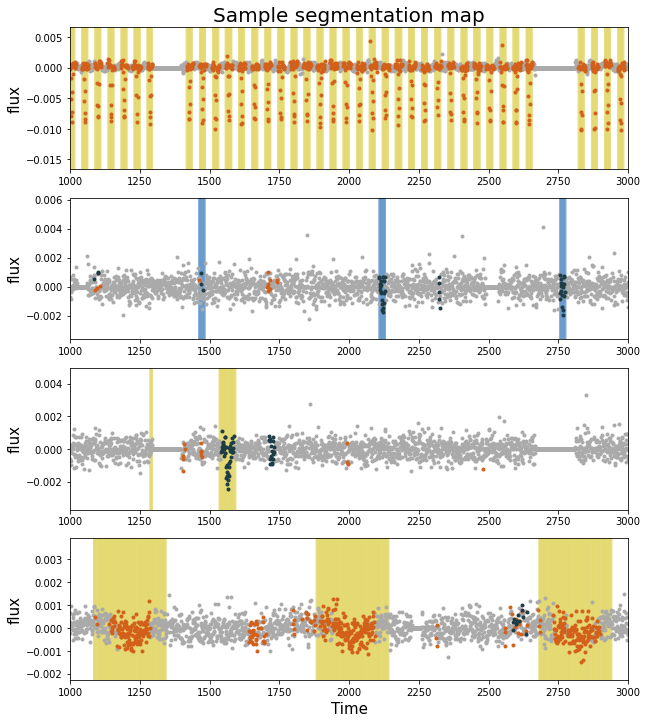

In [39]:
#make some chummy plots
#ar=[0,5,6,11,13]
#ar=np.random.randint(0,len(Xtest),size=6)
#ar = [5,20,10,7,15, 39]
ar = [1,17,21,4]
#ar=[36,37,38,39,40]
#ar=[194,201,202,203,206]

Ytest = np.asarray(Ytest, dtype='float32')
Xtest = np.asarray(Xtest, dtype='float32')
fig,ax=plt.subplots(4,1,figsize=(10,12))
plt.style.use('seaborn-bright')
ax[0].set_title('Sample segmentation map', size=20)
ind=np.arange(0,4000)

for i in range(0,4):
    plotlab=pred_op[ar[i],:,:]
    counts=np.asarray([np.argmax([el[0],el[1],el[2]/1.2]) for el in plotlab])
    pcounts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in Ytest[ar[i],:,:]])
    #if(i==0): counts=np.asarray([np.argmax([el[0],el[1],el[2]/1.4]) for el in plotlab])
    #elif(i==4): counts=np.asarray([np.argmax([el[0],el[1],el[2]/2]) for el in plotlab])

    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    bkg=np.where(counts==2)[0]
    ppl = np.where(pcounts==0)[0]
    pfps = np.where(pcounts==1)[0]
    m = min(Xtest[ar[i]])*1.5
    mx= max(Xtest[ar[i]])*1.5
    ax[i].plot(ind[bkg],Xtest[ar[i],bkg],color='#aaaaaa',marker='.',ls='None',label='bkg')
    ax[i].plot(ind[fps],Xtest[ar[i],fps],color='#d2601a',marker='.',ls='None',label='fps') 
    ax[i].plot(ind[pl],Xtest[ar[i],pl],color='#1d3c45',marker='.',ls='None',label='pl')
    if(len(ppl)>0): ax[i].vlines(x=ppl,ymin=m*2, ymax=mx*2, alpha=0.5, color='#6699CC')
    if(len(pfps)>0): ax[i].vlines(x=pfps,ymin=m*2, ymax=mx*2, alpha=0.5, color='#e4d96f')
    ax[i].set_ylim(m,mx)
    ax[i].set_xlim(1000,3000)
    #ax[i].legend()
    ax[i].set_ylabel('flux', size=15)
    
    #ax[i][0].legend()
ax[3].set_xlabel('Time', size=15)
#ax[3].set_ylim(-0.003,0.002)
plt.savefig('fprez_result2.png')


In [ ]:
#another
class_Ypred=[]
class_Ytest=[]
for i in range(0,len(pred_op)):
    plotlab=pred_op[i,:,:]
    counts=np.asarray([np.argmax([el[0],el[1],el[2]/2]) for el in plotlab])
    pl=(counts==0).sum()
    fps=(counts==1).sum()
    #bkg=(counts==2).sum()
    if(pl==0 and fps ==0): continue
    if(pl>fps): class_Ypred.append(0)
    else: class_Ypred.append(1)

    tpl=Ytest[i,:,0].sum()
    tfps=Ytest[i,:,1].sum()
    if(tpl>tfps): class_Ytest.append(0)
    else: class_Ytest.append(1)

cm=confusion_matrix(np.asarray(class_Ytest),np.asarray(class_Ypred))
print(cm)


In [35]:
#evaluate transits by grouping:
#convNN.load_weights('thisisagoodone.h5')
#pred_op=convNN.predict(np.array(Xtestf))

maxarr_pred = [[ np.argmax(np.asarray([x[0],x[1],x[2]])) for x in el] for el in pred_op]
maxarr_predpl  =[[x==0 for x in el] for el in maxarr_pred]
maxarr_predfps  =[[x==1 for x in el] for el in maxarr_pred]
#maxarr_testpl = [[np.argmax([el[2],el[0]]) for x in el] for el in Xtest]
#maxarr_predfps = [[np.argmax(np.asarray([x[2],x[1]])) for x in el] for el in pred_op]
#maxarr_testfps = [[np.argmax([el[2],el[1]]) for x in el] for el in Xtest]

In [36]:
print(np.asarray(maxarr_predpl).shape)

(1225, 4000)


In [37]:
from scipy.signal import argrelextrema,find_peaks

corrects=np.asarray([[0,0],[0,0]])
newc = 0
newinc = 0
for i in range(0,len(pred_op)):
    tick = 0
    ntick = 0
    plp, _ = find_peaks(maxarr_predpl[i], height=0.0,distance=20) 
    for m in plp:
        if(Ytest[i,m,0]>0.5): 
            corrects[0,0]+=1
            tick+=1
        if(Ytest[i,m,1]>0.5): 
            corrects[1,0]+=1
            ntick+=1
        #if(Ytrain[i,m,2]>0.5): corrects[2,0]+=1
        #else: corrects[2,0]+=1
    fpsp, _ = find_peaks(maxarr_predfps[i], height=0.0,distance=20)
    for m in fpsp:
        if(Ytest[i,m,1]>0.5): 
            corrects[1,1]+=1
            tick+=1
        if(Ytest[i,m,0]>0.5): 
            corrects[0,1]+=1
            ntick+=1
        #if(Ytrain[i,m,2]>0.1): corrects[0,2]+=1
        #else: corrects[0,2]+=1
    if(tick>ntick): newc+=1
    else: newinc+=1

print(corrects/corrects.sum())
print(newinc,newc, newinc/(newc+newinc))
print((corrects[0,0]+corrects[1,1])/corrects.sum())

[[0.21445244 0.09852169]
 [0.0966738  0.59035207]]
558 667 0.4555102040816327
0.804804512740712


In [ ]:
from astropy.io import ascii
from astropy.table import Table
TestID2 = [TestID[i].numpy() for i in range(0,len(TestID))]
TestID2 = [str(TestID2[i])[2:11] for i in range(0,len(TestID2))]
print(TestID2[2:10])
Ytest = np.asarray(Ytest, dtype = 'float32')

for i in range(0,len(Xtest)):
    data = Table()
    data['RAW'] = Xtest[i]
    data['PL_MAP'] = Ytest[i,:,0]
    data['FPS_MAP'] = Ytest[i,:,1]
    data['BKG_MAP'] = Ytest[i,:,2]
    data['PRED_PL_MAP'] = pred_op[i,:,0]
    data['PRED_FPS_MAP'] = pred_op[i,:,1]
    data['PRED_BKG_MAP'] = pred_op[i,:,2]
    ascii.write(data, '../../processed_directories/sem_seg_op/'+str(np.asarray(TestID2)[i]), overwrite=True)
    

In [ ]:
TestID2 = [str(TestID[i])[2:12] for i in range(0,len(TestID))]
#print(TestID2)

In [34]:
#here we are setting up an expanded semantic segmentation problem
import os
from scipy.signal import find_peaks
PATHRV = '../../processed_directories/expand_test_and_noise_rec/'
PATHAV = '../../processed_directories/sem_seg_av_test/'
FOUT = '../../processed_directories/expand_test_result_av/'

def peak_cm(pred_op, true_op):
  maxarr_pred = np.argmax(pred_op,axis=-1)
  maxarr_predpl  = np.asarray(maxarr_pred==0,dtype='int')
  maxarr_predfps  = np.asarray(maxarr_pred==1, dtype='int')

  corrects=np.asarray([[0,0],[0,0]])
  peak_pl=[]
  peak_fps=[]
  for i in range(0,len(pred_op)):
      plp, _ = find_peaks(maxarr_predpl[i], height=0.3,distance=20) 
      peak_pl.append(plp)
      for m in plp:
          if(true_op[i,m,0]>0.5): corrects[0,0]+=1
          #elif(true_op[i,m,1]>0.5): corrects[1,0]+=1
          else: corrects[1,0]+=1
      fpsp, _ = find_peaks(maxarr_predfps[i], height=0.3,distance=20)
      peak_fps.append(fpsp)
      for m in fpsp:
          if(true_op[i,m,1]>0.1): corrects[1,1]+=1
          else: corrects[0,1]+=1

  #print(corrects/corrects.sum())
  #print((corrects[0,0]+corrects[1,1])/corrects.sum())
  #print(corrects[0,0],corrects[1,1])
  corrects = corrects.reshape(-1)
  return(corrects,peak_pl,peak_fps)

#load model or weights...
model = keras.models.load_model('newtests.h5',custom_objects={'focal_dice_loss': focal_dice_loss})
#convNN.load_model('epic_one.h5')

test_dir = os.listdir(PATHAV)
for el in test_dir :
  test1_X, test1_Y= gc.read_tfr_record(PATHAV+el[:9],['input','mask'],['ar','ar'],[tf.float32,tf.bool])
  
  test1_X = np.asarray(test1_X, dtype='float32')
  test1_Y = np.asarray(test1_Y, dtype='float32')
  test1_Y = np.reshape(test1_Y,(len(test1_X),4000,3)) 

  mastermed=np.median(test1_X)
  masterstd=np.std(test1_X)
  #test1_X=np.asarray([(row-mastermed)/(-row[np.argmin(row)]+masterstd) for row in test1_X])
  test1_X=np.asarray([0.5*(np.tanh(0.1*(row - mastermed)/masterstd)) for row in test1_X])

  test_pred = model.predict(test1_X)

  print(el)
  np.reshape(test1_Y,(len(test1_Y),12000))
  np.reshape(test_pred,(len(test_pred),12000))

  net=np.asarray([[test1_X[i],test1_Y[i],test_pred[i],mastermed,masterstd] for i in range(0,len(test1_X))])
  gc.write_tfr_record(FOUT+el, net, ['input', 'true_map', 'pred_map', 'scale_median', 'scale_std'],['ar','ar','ar','fl','fl'],
    ['float32','bool', 'float32','float32','float32'])


001292087
Wrote 17 elements to TFRecord


C:\Program Files\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


001430590
Wrote 17 elements to TFRecord
001571717
Wrote 17 elements to TFRecord
001573174
Wrote 17 elements to TFRecord
001577039
Wrote 17 elements to TFRecord
001717722
Wrote 17 elements to TFRecord
001718189
Wrote 17 elements to TFRecord
001872821
Wrote 17 elements to TFRecord
001996180
Wrote 17 elements to TFRecord
002010191
Wrote 17 elements to TFRecord
002013883
Wrote 17 elements to TFRecord
002014991
Wrote 17 elements to TFRecord
002141783
Wrote 17 elements to TFRecord
002158190
Wrote 17 elements to TFRecord
002166218
Wrote 17 elements to TFRecord
002283124
Wrote 17 elements to TFRecord
002297728
Wrote 17 elements to TFRecord
002297739
Wrote 17 elements to TFRecord
002300603
Wrote 17 elements to TFRecord
002302548
Wrote 17 elements to TFRecord
002303365
Wrote 17 elements to TFRecord
002305866
Wrote 17 elements to TFRecord
002307199
Wrote 17 elements to TFRecord
002310284
Wrote 17 elements to TFRecord
002422539
Wrote 17 elements to TFRecord
002437112
Wrote 17 elements to TFRecord
